In [ ]:
#installing required packages
install.packages('L0Learn')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’, ‘reshape2’, ‘RcppArmadillo’




In [ ]:
library('L0Learn')

# Dataset generation

#### Simulate train and test data with 100 samples, 500 SNPs and 10 acive SNPs

In [ ]:
train_data <- GenSynthetic(n=100,p=500,k=10,seed=1)
X_train = train_data$X
y_train = train_data$y

In [ ]:
test_data <- GenSynthetic(n=50,p=500,k=10,seed=1)
X_test = test_data$X
y_test = test_data$y

#### Apply Logistic function to outputs

In [ ]:
logistic <- function(x){1/(1+exp(-x))}
y_train = lapply(y_train,logistic)
y_train_raw = y_train
y_train = lapply(y_train,function(x){x>=0.5})
y_train = as.numeric(y_train)

y_test = lapply(y_test,logistic)
y_test_raw = y_test
y_test = lapply(y_test,function(x){x>=0.5})
y_test = as.numeric(y_test)

# GLM Model for Logistic regression

#### Fit a generalized linear model of the binomial family, since the data is like SNP present/ not present and summarize the fit results

In [ ]:
glm_data = data.frame(X_train)
glm_data$y = y_train
glm_fit  = glm(formula = y ~ ., data=glm_data, family = binomial)
summary(glm_fit)


Call:
glm(formula = y ~ ., family = binomial, data = glm_data)

Coefficients: (401 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)
(Intercept)  2.484e+00  1.026e+06       0        1
X1           1.423e+00  3.275e+05       0        1
X2           8.213e+00  1.987e+06       0        1
X3           2.451e+01  1.363e+06       0        1
X4           7.536e+00  8.902e+05       0        1
X5          -9.809e+00  7.744e+05       0        1
X6           1.141e+01  1.227e+06       0        1
X7           5.348e+00  1.035e+06       0        1
X8           4.712e+00  5.919e+05       0        1
X9           9.186e+00  1.004e+06       0        1
X10          1.383e+01  8.499e+05       0        1
X11         -1.204e+01  3.336e+05       0        1
X12         -1.184e+01  8.789e+05       0        1
X13         -2.792e-01  8.969e+05       0        1
X14          1.346e+01  6.335e+05       0        1
X15         -1.244e+00  2.485e+05       0        1
X16        

#### Observe that most coefficients have very high p value of 1, Since the model has converged we can still go on with predictions and look at the accuracy

In [ ]:
glm_fit$converged

[1] TRUE

In [ ]:
y_pred_glm <- predict.glm(glm_fit,data.frame(X_test),type='response')

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


In [ ]:
y_pred_glm = as.numeric(y_pred_glm>0.5)
table(pred=y_pred_glm,true=y_test)

    true
pred  0  1
   0 15 12
   1 11 12

In [ ]:
mean(y_pred_glm==y_test)

[1] 0.54

# LASSO

#### Under lasso regularizatiom we penalize the absolute value of model coefficients under the hope that they go to zero and we are able to find active SNPs, we install and use glmnet library for this.

In [ ]:
library(devtools)
install_version("glmnet", version = "3.0-2")
library(glmnet)

Loading required package: usethis




iterators (NA -> 1.0.14) [CRAN]
shape     (NA -> 1.4.6 ) [CRAN]
foreach   (NA -> 1.5.2 ) [CRAN]


Installing 3 packages: iterators, shape, foreach

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix

Loaded glmnet 3.0-2




In [ ]:
lasso_glmnet_fit <- cv.glmnet(X_train,y_train,alpha=1,family='binomial',type.measure = 'mse' )

#### Choosing optimal value of lambda by method in library

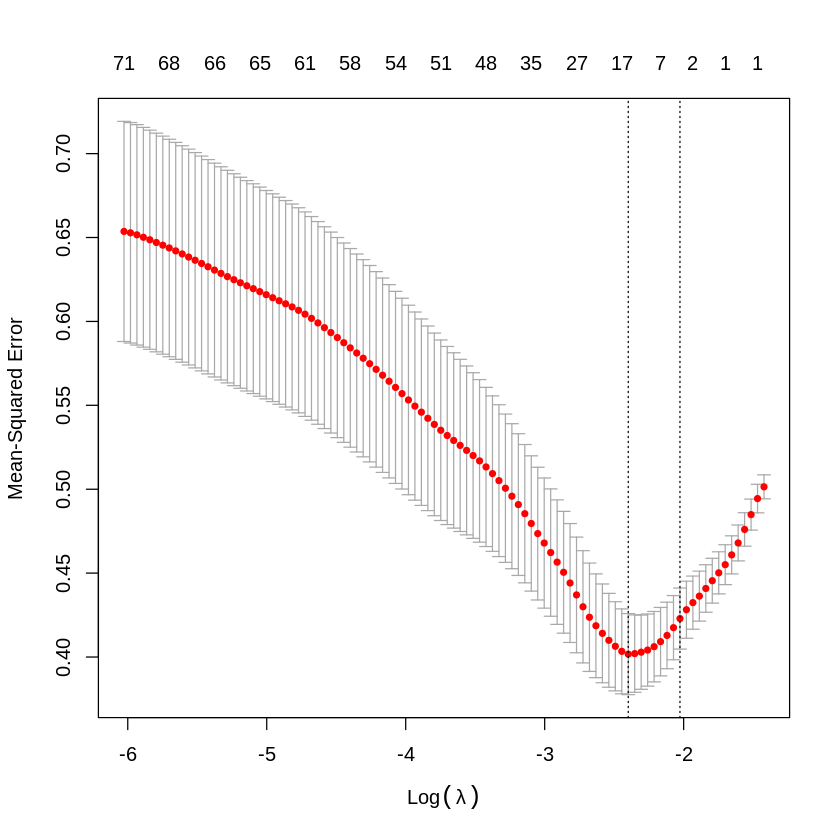

In [ ]:
plot(lasso_glmnet_fit)

In [ ]:
#best lambda value
lasso_glmnet_fit$lambda.1se

[1] 0.1317879

#### Observe non zero model coefficients, here we find sparse coefficient terms, we do not observe the correct first 10 active SNPs however it does work at selecting best coefficients and subsequently good SNP candidates

In [ ]:
coef(lasso_glmnet_fit,s=lasso_glmnet_fit$lambda.1se)

501 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) -0.21754728
V1           .         
V2           .         
V3           .         
V4           0.11200993
V5           .         
V6           .         
V7           .         
V8           .         
V9           0.39078579
V10          .         
V11          .         
V12          .         
V13          .         
V14          .         
V15          .         
V16          .         
V17          .         
V18          .         
V19          .         
V20          .         
V21          .         
V22          0.01370548
V23          .         
V24          .         
V25          .         
V26          .         
V27          .         
V28          .         
V29          .         
V30          .         
V31          .         
V32          .         
V33          .         
V34          .         
V35          .         
V36          .         
V37          .         
V38          .       

In [ ]:
# Total number of non zero coefs
sum(coef(lasso_glmnet_fit,s=lasso_glmnet_fit$lambda.1se)!=0)-1

[1] 5

#### Accuracy

In [ ]:
y_pred_lasso <- predict(lasso_glmnet_fit,newx = X_test,s=lasso_glmnet_fit$lambda.1se,type='response')

In [ ]:
y_pred_lasso = as.numeric(y_pred_lasso>0.5)
table(pred=y_pred_lasso,true=y_test)

    true
pred  0  1
   0 23 12
   1  3 12

In [ ]:
mean(y_pred_lasso==y_test)

[1] 0.7

# RIDGE

#### In ridge we are minimizing the square of the weights along with the error term, this will yield small but non zero values for important coefs usually

In [ ]:
ridge_glmnet_fit <- cv.glmnet(X_train,y_train,alpha=0,family='binomial',type.measure = 'mse' )

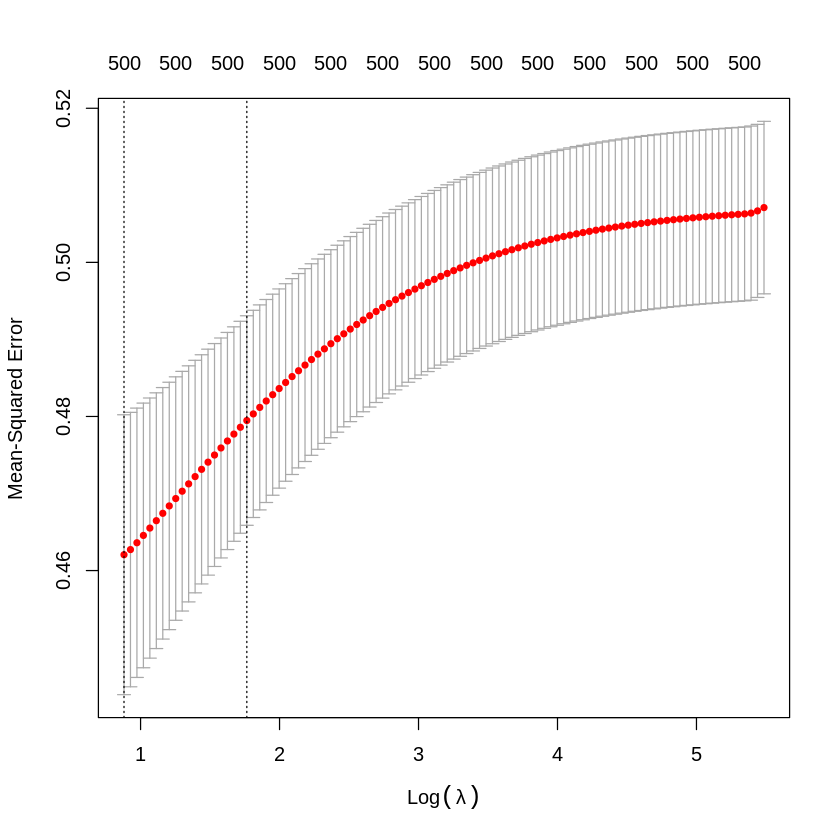

In [ ]:
plot(ridge_glmnet_fit)

In [ ]:
#best lambda value
ridge_glmnet_fit$lambda.1se

[1] 5.839021

In [ ]:
coef(ridge_glmnet_fit,s=ridge_glmnet_fit$lambda.1se)

501 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -1.889124e-01
V1           1.832535e-02
V2           1.421956e-02
V3           1.488574e-02
V4           2.469583e-02
V5           1.626490e-02
V6           8.993045e-03
V7           1.219579e-02
V8           9.805503e-03
V9           3.005134e-02
V10          2.007548e-02
V11         -2.858259e-03
V12         -1.263454e-02
V13         -1.334467e-03
V14         -1.256279e-02
V15         -6.052638e-03
V16          3.435306e-04
V17          1.131320e-02
V18         -5.289133e-03
V19          8.552393e-03
V20         -3.995834e-03
V21          1.090732e-02
V22          1.939009e-02
V23         -2.045883e-03
V24         -2.702100e-03
V25          9.313327e-04
V26          5.018992e-03
V27         -4.340649e-03
V28         -8.843839e-04
V29          8.955562e-03
V30         -5.653625e-03
V31          4.542970e-03
V32         -1.158408e-02
V33         -6.200238e-03
V34          1.512513e-02
V35          2.703852

#### Accuracy

In [ ]:
y_pred_ridge <- predict(ridge_glmnet_fit,newx = X_test,s=ridge_glmnet_fit$lambda.1se,type='response')

In [ ]:
y_pred_ridge = as.numeric(y_pred_ridge>0.5)
table(pred=y_pred_ridge,true=y_test)

    true
pred  0  1
   0 24 18
   1  2  6

In [ ]:
mean(y_pred_ridge==y_test)

[1] 0.6

# Elastic Net

In elastic net we are minimizing both the absolute value of the weights and the square of the weights along with the error term, controlled by a weight parameter alpha, set here to 0.5

In [ ]:
elasticnet_glmnet_fit <- cv.glmnet(X_train,y_train,alpha=0.5,family='binomial',type.measure = 'mse' )

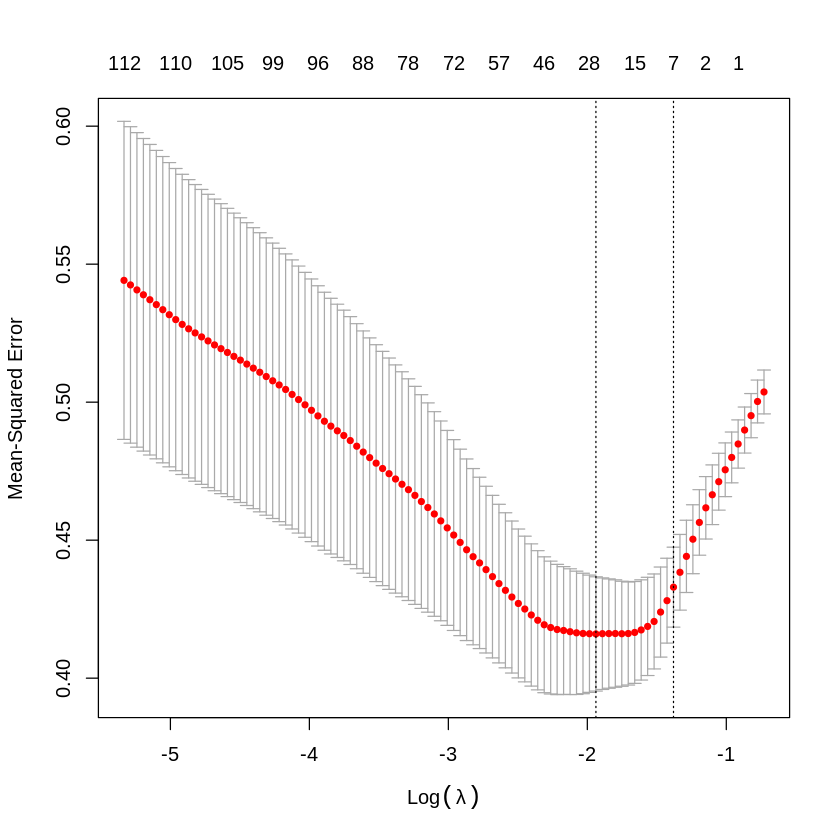

In [ ]:
plot(elasticnet_glmnet_fit)

In [ ]:
#best lambda value
elasticnet_glmnet_fit$lambda.1se

[1] 0.2515958

In [ ]:
elastic_coefs = coef(elasticnet_glmnet_fit,s=elasticnet_glmnet_fit$lambda.1se)
elastic_coefs

501 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) -0.209903017
V1           .          
V2           .          
V3           .          
V4           0.100889681
V5           0.005146074
V6           .          
V7           .          
V8           .          
V9           0.254878832
V10          0.026749886
V11          .          
V12          .          
V13          .          
V14          .          
V15          .          
V16          .          
V17          .          
V18          .          
V19          .          
V20          .          
V21          .          
V22          0.039973985
V23          .          
V24          .          
V25          .          
V26          .          
V27          .          
V28          .          
V29          .          
V30          .          
V31          .          
V32          .          
V33          .          
V34          .          
V35          .          
V36          .          
V37    

In [ ]:
# Total number of non zero coefs
length(elastic_coefs[elastic_coefs!=0])

ERROR: ignored

#### Accuracy

In [ ]:
y_pred_elasticnet <- predict(elasticnet_glmnet_fit,newx = X_test,s=elasticnet_glmnet_fit$lambda.1se,type='response')

In [ ]:
y_pred_elasticnet = as.numeric(y_pred_elasticnet>0.5)
table(pred=y_pred_elasticnet,true=y_test)

    true
pred  0  1
   0 25 15
   1  1  9

In [ ]:
mean(y_pred_elasticnet==y_test)

[1] 0.68

# L0 Learn

#### The best subset selection problem, which is essentially the problem of active SNP selection which we are trying to solve is best modeled by an L0 penalty by penalizing the number of non zero coefficients directly, this is implemented in L0Learn library which we use to detect the proper coefficients using an L0 penalty

In [ ]:
l0learn_fit <- L0Learn.cvfit(X_train, as.numeric(y_train_raw))

In [ ]:
print(l0learn_fit)

lambda,gamma,suppSize
<dbl>,<dbl>,<dbl>
0.128166000,0,0
0.126884000,0,1
0.054732300,0,2
0.046144300,0,3
0.030973500,0,5
0.030425500,0,6
0.027717800,0,7
0.018889500,0,10
0.007104620,0,12


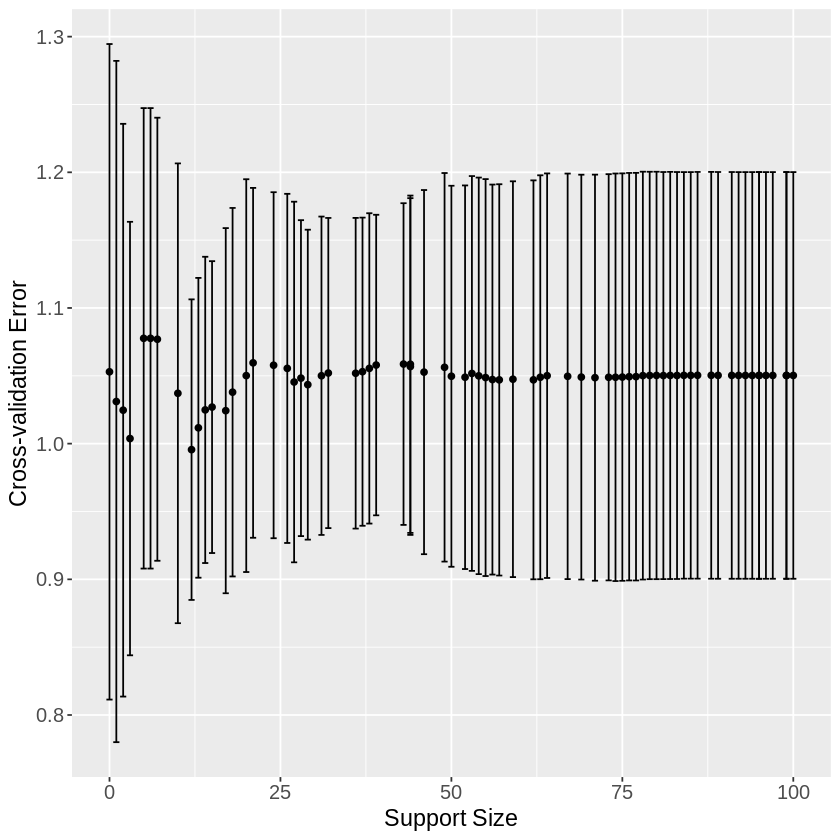

In [ ]:
#observing error values across different support sizes i.e. number of coefs selected by the algorithm, we select the corresponding ;ambda for 10
plot(l0learn_fit, gamma = 0				)

#### Accuracy

In [ ]:
y_pred_l0learn = predict(l0learn_fit,X_test,lambda = 0.018889500		, gamma = 0)

In [ ]:
y_pred_l0learn = as.numeric(y_pred_l0learn>0.5)
table(pred=y_pred_l0learn,true=as.numeric(y_test>0.5))

    true
pred  0  1
   0 25  1
   1  1 23

In [ ]:
mean(y_pred_l0learn==as.numeric(y_test>0.5))

[1] 0.96

#### L0learn finds the correct coefs

In [ ]:
l0_coefs = coef(l0learn_fit,lambda = 0.018889500		, gamma = 0)
l0_coefs

501 x 1 sparse Matrix of class "dgCMatrix"
                    
Intercept 0.48843451
V1        0.09223805
V2        0.10445851
V3        0.10307564
V4        0.11061616
V5        0.08931150
V6        0.09169105
V7        0.09957267
V8        0.08046044
V9        0.10514357
V10       0.12774610
V11       .         
V12       .         
V13       .         
V14       .         
V15       .         
V16       .         
V17       .         
V18       .         
V19       .         
V20       .         
V21       .         
V22       .         
V23       .         
V24       .         
V25       .         
V26       .         
V27       .         
V28       .         
V29       .         
V30       .         
V31       .         
V32       .         
V33       .         
V34       .         
V35       .         
V36       .         
V37       .         
V38       .         
V39       .         
V40       .         
V41       .         
V42       .         
V43       .         
V44       . 

In [ ]:
length(l0_coefs[l0_coefs!=0])-1

<sparse>[ <logic> ]: .M.sub.i.logical() maybe inefficient



[1] 10

# With L0L1 Penalty

In [ ]:
l0learn_fit <- L0Learn.cvfit(X_train, as.numeric(y_train_raw),penalty='L0L1')

In [ ]:
l0learn_fit$fit#[l0learn_fit$fit$gamma==0.5062917]

          lambda        gamma suppSize
1    0.00000e+00 5.062917e-01        0
2    0.00000e+00 5.062917e-01        0
3    0.00000e+00 5.062917e-01        0
4    0.00000e+00 5.062917e-01        0
5    0.00000e+00 5.062917e-01        0
6    0.00000e+00 5.062917e-01        0
7    0.00000e+00 5.062917e-01        0
8    0.00000e+00 5.062917e-01        0
9    0.00000e+00 5.062917e-01        0
10   0.00000e+00 5.062917e-01        0
11   0.00000e+00 5.062917e-01        0
12   0.00000e+00 5.062917e-01        0
13   0.00000e+00 5.062917e-01        0
14   0.00000e+00 5.062917e-01        0
15   0.00000e+00 5.062917e-01        0
16   0.00000e+00 5.062917e-01        0
17   0.00000e+00 5.062917e-01        0
18   0.00000e+00 5.062917e-01        0
19   0.00000e+00 5.062917e-01        0
20   0.00000e+00 5.062917e-01        0
21   0.00000e+00 5.062917e-01        0
22   0.00000e+00 5.062917e-01        0
23   0.00000e+00 5.062917e-01        0
24   0.00000e+00 5.062917e-01        0
25   0.00000e+00 5.062917

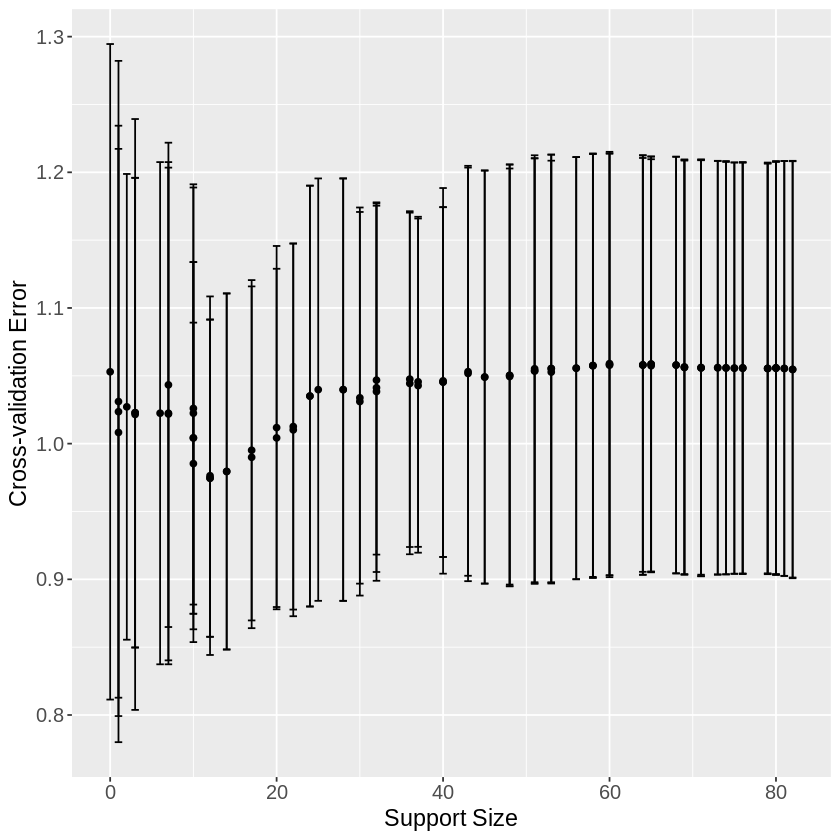

In [ ]:
plot(l0learn_fit, gamma = 5.062917e-05		)

In [ ]:
y_pred_l0learn = predict(l0learn_fit,X_test,lambda = 1.70202e-02, gamma = 5.062917e-05)

In [ ]:
y_pred_l0learn = as.numeric(y_pred_l0learn>0.5)
table(pred=y_pred_l0learn,true=as.numeric(y_test>0.5))

    true
pred  0  1
   0 25  1
   1  1 23

In [ ]:
mean(y_pred_l0learn==as.numeric(y_test>0.5))

[1] 0.96

In [ ]:
l0learn_fit <- L0Learn.cvfit(X_train, as.numeric(y_train_raw),penalty='L0L2')

In [ ]:
l0learn_fit$fit

         lambda        gamma suppSize
1   6.10313e-03 1.000000e+01        0
2   6.04209e-03 1.000000e+01        1
3   3.49328e-03 1.000000e+01        1
4   2.79463e-03 1.000000e+01        5
5   2.47277e-03 1.000000e+01        5
6   1.97822e-03 1.000000e+01        8
7   1.62610e-03 1.000000e+01        8
8   1.30088e-03 1.000000e+01       13
9   1.26185e-03 1.000000e+01       14
10  1.22399e-03 1.000000e+01       14
11  9.79196e-04 1.000000e+01       18
12  9.49820e-04 1.000000e+01       18
13  7.59856e-04 1.000000e+01       27
14  7.37060e-04 1.000000e+01       28
15  7.14948e-04 1.000000e+01       31
16  6.93500e-04 1.000000e+01       33
17  6.72695e-04 1.000000e+01       34
18  6.52514e-04 1.000000e+01       37
19  6.32939e-04 1.000000e+01       42
20  6.13951e-04 1.000000e+01       42
21  4.91160e-04 1.000000e+01       53
22  4.76426e-04 1.000000e+01       55
23  4.62133e-04 1.000000e+01       60
24  4.48269e-04 1.000000e+01       62
25  4.34821e-04 1.000000e+01       66
26  4.21776e

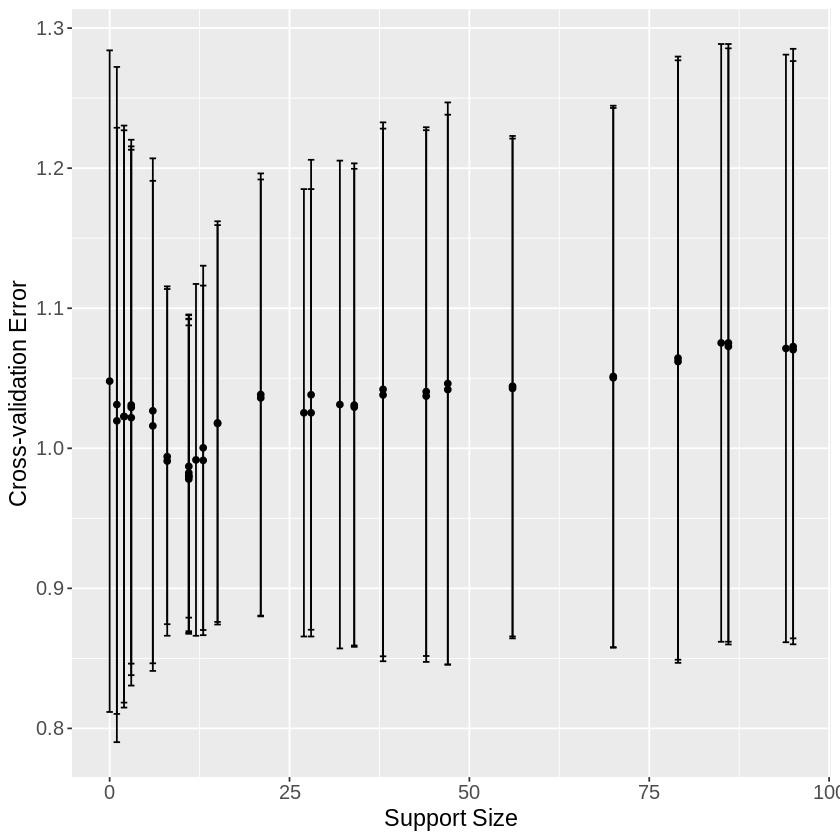

In [ ]:
plot(l0learn_fit, gamma = 2.154435e-01		)

In [ ]:
y_pred_l0learn = predict(l0learn_fit,X_test,lambda = 1.18980e-02, gamma = 2.154435e-01)

In [ ]:
y_pred_l0learn = as.numeric(y_pred_l0learn>0.5)
table(pred=y_pred_l0learn,true=as.numeric(y_test>0.5))

    true
pred  0  1
   0 25  5
   1  1 19

In [ ]:
mean(y_pred_l0learn==as.numeric(y_test>0.5))

[1] 0.88